In [1]:
import os
import time
import json
import parse
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])
from utils import *
from sklearn.metrics import f1_score

files = !ls backup*.txt


df = pd.concat(
    [read_record(file) for file in [
    #"backup_12.txt",
    #"backup_12_1.txt",
    #"backup_12_2.txt",
    "backup_17.txt",
    "backup_17__2.txt",
    "backup_18.txt",
    "backup_18_2.txt",
    "backup_20.txt",
    "backup_20_2.txt",
    "backup_20.txt",
    "backup_20_2.txt"
    ]], ignore_index=True)



In [2]:
df.train.unique()

array(['full', 'dd', 'ok', 'secondary_dd', 'traindev_dd', 'minitrain_dd'],
      dtype=object)

In [3]:
c = df.train.isin("dd,traindev_dd,minitrain_dd".split(","))
c2 = df["eval"] == "test_dd"
df = df[c & c2]
df = df.dropna(axis=0).reset_index()

In [4]:
df["y_pred"] = df.y_pred.apply(to_label)
df["y_true"] = df.y_true.apply(to_label)

In [5]:
df.sample(5)

,index,microF1,macroF1,train,eval,y_true,y_pred
5,75,0.599,0.593,dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
22,139,0.599,0.488,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
21,138,0.629,0.538,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
11,128,0.629,0.538,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
8,125,0.624,0.577,traindev_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."


# Constructing the data for the barh plot

In [6]:
original = pd.read_csv("/home/peterr/macocu/task5_webgenres/data/interim/tabular_1d.csv")
length = original.shape[0]
percentages = dict()
for label in train_labels_no_prefix:
    percentages[label] = len(original[original.primary==label])/length
del original

In [7]:
to_plot = dict()
to_plot["frequency"] = percentages


for name, setting in zip(["40%", "60%", "80%"],["minitrain_dd", "dd", "traindev_dd"]):
    subset = df[df.train == setting].copy()
    y_trues = list()
    for l in subset.y_true.values:
        y_trues.extend(l)
    y_preds = list()
    for l in subset.y_pred.values:
        y_preds.extend(l)
    from sklearn.metrics import f1_score
    f1s = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average=None)
    current = {label: f1 for label, f1 in zip(train_labels_no_prefix, f1s)}
    macrof1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="macro")
    current["macroF1"] = macrof1
    microf1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="micro")
    current["microF1"] = microf1
    to_plot[name] = current



In [8]:
pd.DataFrame(to_plot)

,frequency,40%,60%,80%
Legal/Regulation,0.017,0.333,0.800,0.833
Opinionated News,0.089,0.582,0.635,0.615
News/Reporting,0.115,0.601,0.623,0.619
Forum,0.052,0.893,0.894,0.862
Correspondence,0.016,0.489,0.698,0.566
Invitation,0.032,0.568,0.475,0.575
Instruction,0.038,0.676,0.697,0.519
Recipe,0.006,1.000,1.000,1.000
Opinion/Argumentation,0.114,0.466,0.447,0.482
Promotion of Services,0.032,0.533,0.538,0.694


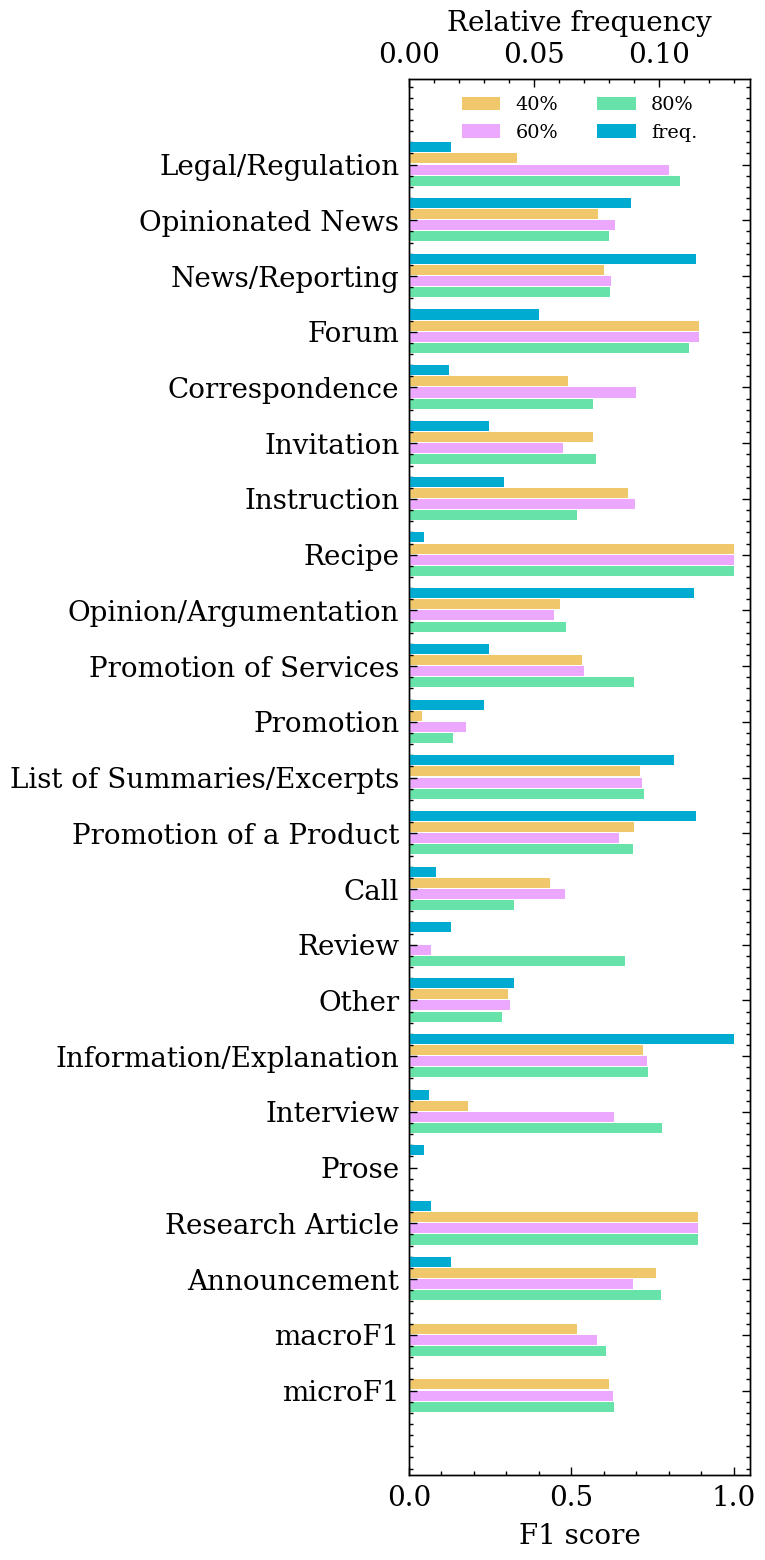

In [9]:
plotdf = pd.DataFrame(to_plot)
fig, ax = plt.subplots(figsize=(4,8), dpi=200)
spread_factor = 5
labels = train_labels_no_prefix + ["macroF1", "microF1"]
ind = np.arange(len(labels))*spread_factor

col = "40%"
sep = 1
height = 0.9
lines = list()

colors = ["#f1c76b",
"#eba8fe",
"#67e3a9",
"#00abd2"]
for i, col in enumerate(["40%", "60%", "80%"]):
    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, label=col, color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("F1 score")

ax2 = plt.twiny(ax)
lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize="x-small", ncol=2, loc=9)
plt.tight_layout()
plt.savefig("paper/Q3_2.png")
plt.savefig("paper/Q3_2.pdf")
plt.show()


# Q2 significance

In [39]:
df = pd.concat(
    [read_record(file) for file in [
    # "backup_12.txt",
    #"backup_12_1.txt",
    #"backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
    "backup_17.txt",
    #"backup_17__2.txt",
    "backup_18.txt",
    #"backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt"
    ]], ignore_index=True)

In [40]:
c1 = df.train == "dd"
c2 = df.train == "secondary_dd"

c = df["eval"] == "test_dd"

nruns = min(df[c & c2].shape[0], df[c & c1].shape[0])
nruns

5

In [41]:
from scipy import stats

# Macro F1:
#Candidate:
higher = df.loc[c & c1,"macroF1"][:nruns]
#Alternative
lower = df.loc[c & c2, "macroF1"][:nruns]

# print(f"Wilcoxon p value: {stats.wilcoxon(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"Student p value: {stats.ttest_ind(higher,lower)[1]:0.3}", "\t\t(null hypothesis: samples have identical average, equal variance is assumed but not necessary)")
import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.00609 		(alternative hypothesis: first is greater than the second)
Student p value: 0.00241 		(null hypothesis: samples have identical average, equal variance is assumed but not necessary)
Higher average: 0.6074, lower average: 0.5379


In [42]:
# Micro F1:
#Candidate:
higher = df.loc[c & c1,"microF1"][:nruns]
#Alternative
lower = df.loc[c & c2, "microF1"][:nruns]

# print(f"Wilcoxon p value: {stats.wilcoxon(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"Student p value: {stats.ttest_ind(higher,lower)[1]:0.3}", "\t\t(null hypothesis: samples have identical average, equal variance is assumed but not necessary)")
import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.102 		(alternative hypothesis: first is greater than the second)
Student p value: 0.308 		(null hypothesis: samples have identical average, equal variance is assumed but not necessary)
Higher average: 0.6335, lower average: 0.6234


# Q4 : does downcasting labels improve results?

In [23]:
df = pd.concat(
    [read_record(file) for file in [
    "backup_12.txt",
    "backup_12_1.txt",
    "backup_12_2.txt",
    "backup_15.txt",
    "backup_16.txt",
    "backup_17.txt",
    "backup_17__2.txt",
    "backup_18.txt",
    "backup_18_2.txt",
    "backup_20.txt",
    "backup_20_2.txt",
    "backup_20.txt",
    "backup_20_2.txt",
    "backup_21.txt",
    ]], ignore_index=True)
df.train.unique(), df["eval"].unique()

(array(['ok', 'full', 'dd', 'OK', 'secondary_dd', 'traindev_dd',
        'minitrain_dd', 'downsampled_dd'], dtype=object),
 array(['test_full', 'test_dd', 'dev_full', 'dev_dd', 'devtest_full',
        'devtest_dd', 'downsampled_test_dd', 'downsampled_dev_dd'],
       dtype=object))

In [24]:
c1 = df.train == "dd"
c2 = df.train == "secondary_dd"

c = df["eval"] == "test_dd"


In [26]:
df[c&(c1|c2)].groupby("train")["microF1,macroF1".split(",")].agg(["mean", "std", "count"])

microF1              macroF1             
                mean    std count    mean    std count
train                                                 
dd             0.629  0.016    52   0.575  0.038    52
secondary_dd   0.635  0.012    15   0.558  0.027    15

In [30]:
nruns = min(df[c&c1].shape[0], df[c&c2].shape[0])

# Micro F1:
#Candidate:
higher = df.loc[c & c2,"microF1"][:nruns]
#Alternative
lower = df.loc[c & c1, "microF1"][:nruns]


print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.0348 		(alternative hypothesis: first is greater than the second)
Higher average: 0.6345, lower average: 0.624


In [61]:
nruns = min(df[c&c1].shape[0], df[c&c2].shape[0])

# Macro F1:
#Candidate:
higher = df.loc[c & c1,"macroF1"][:nruns]
#Alternative
lower = df.loc[c & c2, "macroF1"][:nruns]


print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.339 		(alternative hypothesis: first is greater than the second)
Higher average: 0.5599, lower average: 0.5578


# Q1 revisited

In [28]:
df = pd.concat(
    [read_record(file) for file in [
     "backup_12.txt",
     "backup_12_1.txt",
     "backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
     "backup_17.txt",
     "backup_17__2.txt",
    # "backup_18.txt",
    # "backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_21.txt",
    ]], ignore_index=True)
df = df.dropna().reset_index(drop=True)
df.train.unique(), df["eval"].unique()

(array(['ok', 'full', 'dd'], dtype=object),
 array(['test_full', 'test_dd', 'dev_full', 'dev_dd', 'devtest_dd'],
       dtype=object))

In [42]:
c1 = df.train == "dd"
c2 = df.train == "full"

c3 = df["eval"] == "test_dd"
c4 = df["eval"] == "test_full"
subset = df[(c1&c3)|(c2&c4)]

subset.groupby("train,eval".split(","))["microF1,macroF1".split(",")].agg(["mean", "std"])

microF1        macroF1       
                   mean    std    mean    std
train eval                                   
dd    test_dd     0.629  0.016   0.572  0.037
full  test_full   0.609  0.020   0.595  0.034

In [32]:
nruns = min(df[c1&c3].shape[0], df[c4&c2].shape[0])

# Micro F1:
#Candidate:
higher = df.loc[c3 & c1,"microF1"][:nruns]
#Alternative
lower = df.loc[c4 & c2, "microF1"][:nruns]
from scipy import stats

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.3}, lower average: {np.mean(lower):0.3}")

MannWhithey p value: 3.27e-05 		(alternative hypothesis: first is greater than the second)
Higher average: 0.629, lower average: 0.609


In [43]:
nruns = min(df[c1&c3].shape[0], df[c4&c2].shape[0])

# Macro F1:
#Candidate:
higher = df.loc[c4 & c2,"macroF1"][:nruns]
#Alternative
lower = df.loc[c3 & c1, "macroF1"][:nruns]


print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.3}, lower average: {np.mean(lower):0.3}")

MannWhithey p value: 0.00726 		(alternative hypothesis: first is greater than the second)
Higher average: 0.595, lower average: 0.569


In [54]:
df = pd.concat(
    [read_record(file) for file in [
     "backup_12.txt",
     "backup_12_1.txt",
     "backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
     "backup_17.txt",
     "backup_17__2.txt",
    # "backup_18.txt",
    # "backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_21.txt",
    ]], ignore_index=True)
df = df.dropna().reset_index(drop=True)
print(df.train.unique(), df["eval"].unique())

c1 = df.train == "dd"
c2 = df.train == "full"

c3 = df["eval"] == "test_dd"
c4 = df["eval"] == "test_full"

c5 = df["eval"].isin(["test_dd", "dev_dd"])
c6 = df["eval"].isin(["test_full", "dev_full"])
subset = df[(c1&c5)|(c2&c6)]
print(subset.train.unique(), subset["eval"].unique())
subset.groupby("train".split(","))["microF1,macroF1".split(",")].agg(["mean", "std"])

['ok' 'full' 'dd'] ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_dd']
['full' 'dd'] ['test_full' 'dev_full' 'dev_dd' 'test_dd']


microF1        macroF1       
         mean    std    mean    std
train                              
dd      0.614  0.021   0.563  0.039
full    0.596  0.021   0.558  0.050

In [55]:
nruns = min(df[c1&c5].shape[0], df[c6&c2].shape[0])

# Micro F1:
#Candidate:
higher = df.loc[c5 & c1,"microF1"][:nruns]
#Alternative
lower = df.loc[c6 & c2, "microF1"][:nruns]
from scipy import stats
print("Micro:")
print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.3}, lower average: {np.mean(lower):0.3}")



nruns = min(df[c1&c3].shape[0], df[c4&c2].shape[0])

# Macro F1:
#Candidate:
higher = df.loc[c5 & c1, "macroF1"][:nruns]
#Alternative
lower = df.loc[c6 & c2,"macroF1"][:nruns]
print("Macro:")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

import numpy as np
print(f"Higher average: {np.mean(higher):0.3}, lower average: {np.mean(lower):0.3}")

Micro:
MannWhithey p value: 3.4e-06 		(alternative hypothesis: first is greater than the second)
Higher average: 0.613, lower average: 0.596
Macro:
MannWhithey p value: 0.706 		(alternative hypothesis: first is greater than the second)
Higher average: 0.558, lower average: 0.564


# Fasttext stats

In [57]:
import numpy as np

dedup_macros = [0.2857071869909201, 0.21658307591811427, 0.19719524608431258, 0.2780144106268544, 0.25531453500203505, 0.24581870675620676, 0.23545801642744366, 0.23563435833172675, 0.2383971216691805, 0.1611904761904762, 0.2213362332112332, 0.23837804352510233, 0.1707476825075509, 0.26937347541264334, 0.16604173604173603, 0.217774259462239, 0.18686368778280543, 0.20113260582010584, 0.18032280219780217, 0.14008287370356334]
dedup_micros = [0.42857142857142855, 0.36363636363636365, 0.31137724550898205, 0.39285714285714285, 0.40718562874251496, 0.3493975903614458, 0.3734939759036145, 0.3515151515151515, 0.37575757575757573, 0.31137724550898205, 0.35714285714285715, 0.3373493975903615, 0.30120481927710846, 0.4166666666666667, 0.30952380952380953, 0.36363636363636365, 0.3414634146341463, 0.32727272727272727, 0.3333333333333333, 0.2857142857142857]

print(f"Micro: {np.mean(dedup_micros):0.3}\pm {np.std(dedup_micros):0.2}")
print(f"Macro: {np.mean(dedup_macros):0.3}\pm {np.std(dedup_macros):0.2}")


Micro: 0.352\pm 0.038
Macro: 0.217\pm 0.04


# Plotting CM

part 1: full label set

In [2]:
df = pd.concat(
    [read_record(file) for file in [
     "backup_12.txt",
     "backup_12_1.txt",
     "backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
     "backup_17.txt",
     "backup_17__2.txt",
    # "backup_18.txt",
    # "backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_21.txt",
    ]], ignore_index=True)
df = df.dropna().reset_index(drop=True)
print(df.train.unique(), df["eval"].unique())

c1 = df.train == "dd"

c2 = df["eval"] == "test_dd"

df[c1&c2].sort_values("microF1", ascending=False)[0:3]

['ok' 'full' 'dd'] ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_dd']


,microF1,macroF1,y_true,y_pred,train,eval
305,0.675,0.622,"[__label__Promotion_of_a_Product, __label__Pro...","[__label__Promotion_of_a_Product, __label__Pro...",dd,test_dd
343,0.655,0.604,"[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...",dd,test_dd
183,0.655,0.622,"[__label__Promotion_of_a_Product, __label__Pro...","[__label__Promotion_of_a_Product, __label__Pro...",dd,test_dd


microF1=0.6751
macroF1=0.6222


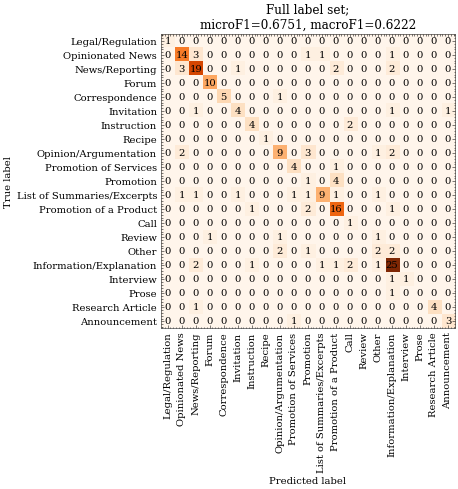

microF1=0.6751
macroF1=0.6222


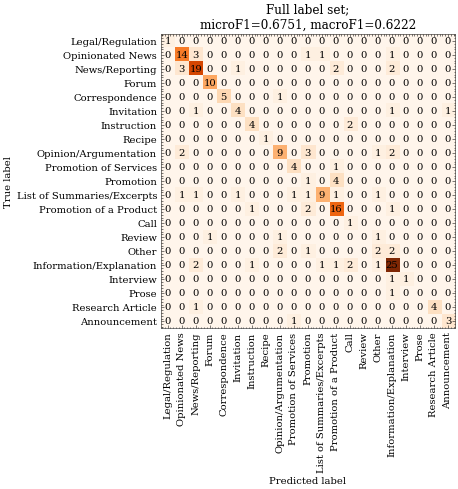

(0.6751269035532995, 0.6222073034702434)

In [8]:
i = 305
y_true = df.loc[305, "y_true"]
y_pred = df.loc[305, "y_pred"]

y_true = [NUM_TO_STR_NO_PREFIX[STR_TO_NUM[i]] for i in y_true]
y_pred = [NUM_TO_STR_NO_PREFIX[STR_TO_NUM[i]] for i in y_pred]

plot_cm(y_true, y_pred, labels=train_labels_no_prefix,
        title="Full label set", include_metrics=True,
        figsize=(7,7),
        save="/home/peterr/macocu/task5_webgenres/paper/CM_full_labels.pdf"
        )
plot_cm(y_true, y_pred, labels=train_labels_no_prefix,
        title="Full label set", include_metrics=True,
        figsize=(7,7),
        save="/home/peterr/macocu/task5_webgenres/paper/CM_full_labels.png"
        )

Part 2: reduced label set

In [10]:
df = pd.concat(
    [read_record(file) for file in [
    #  "backup_12.txt",
    #  "backup_12_1.txt",
    #  "backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
    #  "backup_17.txt",
    #  "backup_17__2.txt",
    # "backup_18.txt",
    # "backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    "backup_21.txt",
    ]], ignore_index=True)
df = df.dropna().reset_index(drop=True)
print(df.train.unique(), df["eval"].unique())

c1 = df.train == "downsampled_dd"

c2 = df["eval"] == "downsampled_test_dd"

df[c1&c2].sort_values("microF1", ascending=False)[0:3]

['downsampled_dd'] ['downsampled_test_dd' 'downsampled_dev_dd']


,microF1,macroF1,y_true,y_pred,train,eval
0,0.706,0.368,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
6,0.706,0.357,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
2,0.701,0.393,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd


microF1=0.7005
macroF1=0.6882


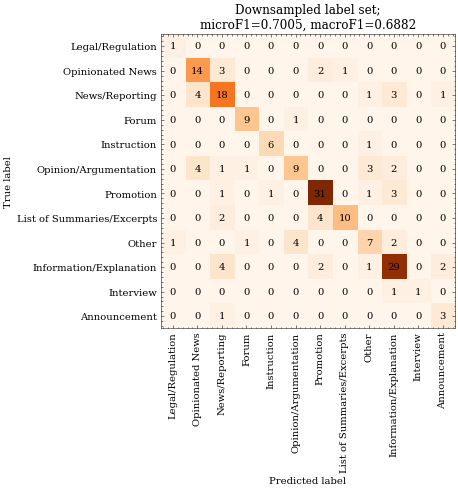

microF1=0.7005
macroF1=0.6882


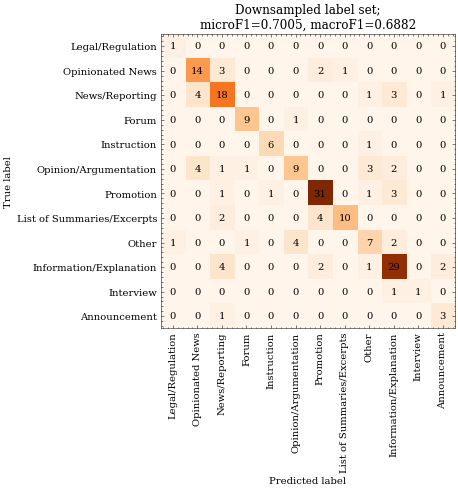

(0.700507614213198, 0.6881795837553639)

In [13]:
i = 2
y_true = df.loc[i, "y_true"]
y_pred = df.loc[i, "y_pred"]

y_true = [REDUCED_NUM_TO_STR_NO_PREFIX[i] for i in y_true]
y_pred = [REDUCED_NUM_TO_STR_NO_PREFIX[i] for i in y_pred]

plot_cm(y_true, y_pred, labels=reduced_labels_no_prefix,
        title="Downsampled label set", include_metrics=True,
        figsize=(7,7),
        save="/home/peterr/macocu/task5_webgenres/paper/CM_downsampled_labels.pdf"
        )
plot_cm(y_true, y_pred, labels=reduced_labels_no_prefix,
        title="Downsampled label set", include_metrics=True,
        figsize=(7,7),
        save="/home/peterr/macocu/task5_webgenres/paper/CM_downsampled_labels.png"
        )

# Dealing with only_keep phenomenon

In [22]:
df = pd.concat(
    [read_record(file) for file in [
     "backup_12.txt",
     "backup_12_1.txt",
     "backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
    #  "backup_17.txt",
    #  "backup_17__2.txt",
    # "backup_18.txt",
    # "backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_21.txt",
    ]], ignore_index=True)
#df = df.dropna().reset_index(drop=True)
print(df.train.unique(), df["eval"].unique())
c = df["eval"].str.contains("test")

df.groupby("train,eval".split(","))[["microF1", "macroF1"]].agg(["mean", "std","count"])

['ok' 'full' 'dd'] ['test_full' 'test_dd' 'dev_full' 'dev_dd']


microF1              macroF1             
                   mean    std count    mean    std count
train eval                                               
dd    dev_dd      0.600  0.014    41   0.556  0.038    41
      dev_full    0.535  0.019    41   0.468  0.052    41
      test_dd     0.629  0.016    41   0.571  0.039    41
      test_full   0.555  0.023    41   0.515  0.037    41
full  dev_dd      0.626  0.017    35   0.573  0.030    35
      dev_full    0.583  0.014    35   0.521  0.032    35
      test_dd     0.608  0.016    35   0.548  0.023    35
      test_full   0.609  0.020    35   0.595  0.034    35
ok    test_dd     0.673  0.018    15   0.650  0.028    15
      test_full   0.560  0.026    15   0.551  0.038    15